# Submission Information:

### Team Member 1:
* UNI: ia2221
* Name: Ignacio Aranguren
* Team Name: nachoaz

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [1]:
%matplotlib notebook
%matplotlib inline

from __future__ import division
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fancyimpute
import mglearn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (train_test_split, 
     GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import Imputer
from imblearn.pipeline import Pipeline as imb_Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

orig_data = pd.read_csv('final_data//data.csv')

Let's see what the data looks like.

In [2]:
# orig_data.iloc[0:10,:]

What do these different data values represent? Which ones should we not use? (Remember: we're trying to predict whether or not a person will buy a certain one of the bank's products, but we don't want to even bother the ones that are highly unlikely to buy. So we have to use features that are available before making the promotional call to that person.)

Let's also take this as an opportunity to see what kinds of features we're working with and the possible values they can take on are.

In [3]:
# !cat data/data_dictionary.txt

So we see that we have 20 features, 10 of which are numeric and 10 of which are categorical. To avoid using information that wouldn't be available before the first call, we're instructed not to use the feature 'duration'; everything else we can use.

Let's get rid of that feature.

In [4]:
data = orig_data.drop('duration', axis=1)

Let's now split our data into a train set and a test set.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
     data.drop('subscribed', axis=1).values, 
     data['subscribed'].values,
     stratify=data['subscribed'].values,
     random_state=0)





# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

In [6]:
train_df = pd.DataFrame(X_train, columns=data.columns[:-1])
train_df['subscribed'] = y_train

train_df.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,52,blue-collar,married,basic.4y,unknown,no,no,telephone,may,thu,15,999,0,nonexistent,1.17826,94.2367,-37.0486,4.74608,5192,no
1,41,blue-collar,single,basic.6y,unknown,yes,no,cellular,apr,fri,4,999,1,failure,-2.00094,94.1037,-46.0965,1.42721,5096,no
2,36,entrepreneur,single,university.degree,no,yes,no,telephone,jun,fri,1,999,0,nonexistent,1.33155,94.79,-41.7284,4.99052,5227,no
3,46,blue-collar,divorced,unknown,no,no,no,cellular,jul,tue,8,999,0,nonexistent,1.33587,94.5252,-42.9314,5.07024,5233,no
4,51,management,married,university.degree,no,yes,no,telephone,jun,fri,3,999,0,nonexistent,1.46837,94.1738,-42.6451,5.11396,5228,no


We've already seen what kind of variables we're working with. Let's now see how they're distributed and think about how we might encode or transform them.

More specifically, let's see what the categories are for categorical variables, and let's look for differences in spelling and capitalization that might require preprocessing.

First, I should convert the data types of the noncategorical features to numeric. That way, I'll then more easily be able to see the different values that the categorical features take on, and perhaps do some plotting (barcharts for categorical features, a scatterplot of the numerical features).

In [7]:
for col in train_df.columns:
    if isinstance(train_df[col][0], int):
        train_df[col] = train_df[col].apply(pd.to_numeric, errors='coerce')
    elif isinstance(train_df[col][0], float):
        train_df[col] = train_df[col].apply(pd.to_numeric, errors='coerce')
        
train_df.dtypes

age               float64
job                object
marital_status     object
education          object
credit_default     object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign          float64
prev_days           int64
prev_contacts       int64
prev_outcomes      object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
subscribed         object
dtype: object

It stands out to me that age got converted to a float, although I'd think that the measurements on that feature for all examples would be an integer. I'll investigate this further by looking at remainders.

In [8]:
from math import floor
all([num == floor(num) for num in train_df['age']])

True

So it looks like they're all integers. I'll move forward for now. Back to checking what categories each categorical variable takes on.

In [9]:
for col in train_df.select_dtypes(exclude=['int64', 'float64']).columns:
     print('\n{}\n{}'.format(col, train_df[col].value_counts()))


job
admin.           6297
blue-collar      5587
technician       4059
services         2362
management       1751
retired          1026
entrepreneur      887
self-employed     817
housemaid         631
unemployed        578
student           531
unknown           186
Name: job, dtype: int64

marital_status
married     14961
single       6958
divorced     2749
unknown        44
Name: marital_status, dtype: int64

education
university.degree      7293
high.school            5674
basic.9y               3684
professional.course    3150
basic.4y               2457
basic.6y               1398
unknown                1045
illiterate               11
Name: education, dtype: int64

credit_default
no         19570
unknown     5140
yes            2
Name: credit_default, dtype: int64

housing
yes        12838
no         11284
unknown      590
Name: housing, dtype: int64

loan
no         20483
yes         3639
unknown      590
Name: loan, dtype: int64

contact
cellular     15703
telephone     9009


The above summary is a good way to get a detailed view of the breakdown of categories by variable. For a quicker and more qualitative view, it's easier to draw barcharts.

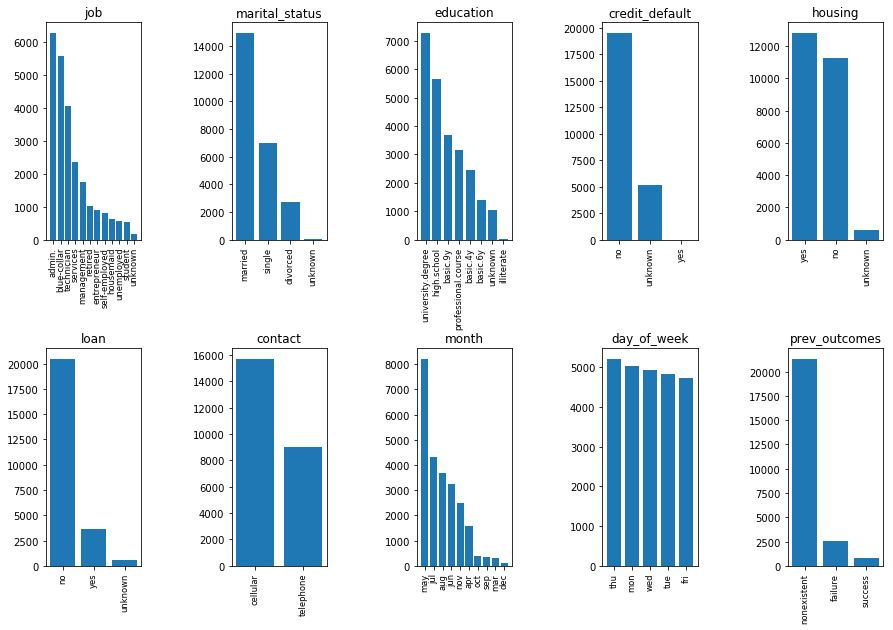

In [10]:
fig, axarr = plt.subplots(2, 5)
cat_cols = train_df.select_dtypes(exclude=['int64', 'float64']).columns
i = 0

for x in np.arange(2):
    for y in np.arange(5):
        x_pos = np.arange(len(train_df[cat_cols[i]].value_counts().keys()))
        vals = train_df[cat_cols[i]].value_counts().values
        axarr[x,y].bar(x_pos, vals)
        axarr[x,y].set_xticks(x_pos)
        axarr[x,y].set_xticklabels(train_df[cat_cols[i]].value_counts().keys(), rotation=90, size='small')
        axarr[x,y].set_title(cat_cols[i])
        i+=1

fig.subplots_adjust(wspace=0.95, hspace=0.5)
fig.set_figheight(10)
fig.set_figwidth(15)


Now I build a scatterplot matrix to look at the continuous variables.

In [11]:
# # the rotating of the axes here was done by following the example in:
# # http://stackoverflow.com/questions/26975089/making-the-labels-of-the-scatterplot-vertical-and-horizontal-in-pandas

# max_prev_days = sorted(set(train_df['prev_days'].values), reverse=True)[1]

# axs = pd.scatter_matrix(train_df.select_dtypes(exclude=['object']), c=[1 if y == 'yes' else 0 for y in y_train])
# n = len(train_df.select_dtypes(exclude=['object']).columns)

# for x in range(n):
#     for y in range(n):
#         # to get the axis of subplots
#         ax = axs[x, y]
        
#         if x == 2:
#             ax.set_ylim([0, max_prev_days])
            
#         if y == 2:
#             ax.set_xlim([0, max_prev_days])
            
#         # to make x axis name vertical  
#         ax.xaxis.label.set_rotation(90)
#         ax.xaxis.label.set_size(6)
#         for tick in ax.xaxis.get_major_ticks():
#             tick.label.set_fontsize(6)
        
#         # to make y axis name horizontal 
#         ax.yaxis.label.set_rotation(0)
#         ax.yaxis.label.set_size(6)
#         for tick in ax.yaxis.get_major_ticks():
#             tick.label.set_fontsize(6)
        
#         # to make sure y axis names are outside the plot area
#         ax.yaxis.labelpad = 50

So I see that some of my numerical variables (such as `emp_var_rate`, `euribor3m`, and `nr_employed`) seem to be very much not normally distributed. I also see that most of my variables have different ranges. This indicates that pre-processing will be required, especially for fitting linear models.

Let's see what the ranges of my categorical variables are.

In [12]:
# my_boxplot = plt.boxplot(train_df.select_dtypes(exclude=['object']).values)
# my_ticks = plt.xticks(np.arange(1, train_df.select_dtypes(exclude=['object']).values.shape[1]+1), 
#           train_df.select_dtypes(exclude=['object']).keys(), rotation=30, ha='right')

Let's look at some of the ways we might transform this, to try to gain some intuition as to which transformation might be best.

In [13]:
# my_boxplot = plt.boxplot(RobustScaler().fit_transform(train_df.select_dtypes(exclude=['object']).values))
# my_ticks = plt.xticks(np.arange(1, train_df.select_dtypes(exclude=['object']).values.shape[1]+1), 
#           train_df.select_dtypes(exclude=['object']).keys(), rotation=30, ha='right')

In [14]:
# my_boxplot = plt.boxplot(MinMaxScaler().fit_transform(train_df.select_dtypes(exclude=['object']).values))
# my_ticks = plt.xticks(np.arange(1, train_df.select_dtypes(exclude=['object']).values.shape[1]+1), 
#           train_df.select_dtypes(exclude=['object']).keys(), rotation=30, ha='right')

Let's also think about what missing values we might have, and how we might impute them. We know from the data dictionary that when prev_days is 999, that means that that particular client hasn't been contacted about an offer before. This is valuable information to keep. If we were to one-hot encode our data, we'll end up with a feature that is called something like `prev_days_is_999` which will take on a value of 1 when `prev_days` is 999 (ie when the client has never before been contacted), and a value of 0 when `prev_days` is _not_ 999 (ie when the client has been contacted before); we can thereore think of `prev_days_is_999` as `never_contacted`. But one-hot encoding this particular variable will result in too many added variables; moreover, it'd be more interpretable (and probably better for modeling) to treat this as a continuous variable. Therefore, what we'll do is we'll create a `has_been_contacted_before` categorical variable and we'll leave `prev_days` as a numerical variable.

In [15]:
train_df['never_contacted'] = train_df['prev_days'] == 999
train_df = train_df[list(train_df.columns[:-2]) + list([train_df.columns[-1]]) + list([train_df.columns[-2]])]
train_df.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,...,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,never_contacted,subscribed
0,52.0,blue-collar,married,basic.4y,unknown,no,no,telephone,may,thu,...,999,0,nonexistent,1.178261,94.236694,-37.048583,4.746075,5192.0,True,no
1,41.0,blue-collar,single,basic.6y,unknown,yes,no,cellular,apr,fri,...,999,1,failure,-2.000945,94.103725,-46.096535,1.427209,5096.0,True,no
2,36.0,entrepreneur,single,university.degree,no,yes,no,telephone,jun,fri,...,999,0,nonexistent,1.331550,94.790008,-41.728380,4.990515,5227.0,True,no
3,46.0,blue-collar,divorced,unknown,no,no,no,cellular,jul,tue,...,999,0,nonexistent,1.335875,94.525150,-42.931450,5.070245,5233.0,True,no
4,51.0,management,married,university.degree,no,yes,no,telephone,jun,fri,...,999,0,nonexistent,1.468371,94.173802,-42.645052,5.113962,5228.0,True,no


We also see that a lot of our categorical variables (`job`, `marital_status`, `education`, `credit_default`, `housing`, `loan`) have an 'unknown' category. We can treat these as an additional category or state that each of these values can take on, and so one-hot encoding will take care of this.

Let's now do one-hot encoding of our data. To avoid to problem where not all categories are represented in the converted data, IMLP recommends that we do this using the entire dataset (train and test), or that we do this using our train data but make sure that the names of the transformed columns are consistent to make sure that the semantics remain the same.

I'll do the former.

First, I build a test_df, convert data types, and concatenate test_df and train_df.

In [16]:
test_df = pd.DataFrame(X_test, columns=data.columns[:-1])
test_df['subscribed'] = y_test

for col in test_df.columns:
    if isinstance(test_df[col][0], int):
        test_df[col] = test_df[col].apply(pd.to_numeric, errors='coerce')
    elif isinstance(test_df[col][0], float):
        test_df[col] = test_df[col].apply(pd.to_numeric, errors='coerce')
        
test_df['never_contacted'] = test_df['prev_days'] == 999
test_df = test_df[list(test_df.columns[:-2]) + list([test_df.columns[-1]]) + list([test_df.columns[-2]])]
        
c_df = pd.concat([train_df, test_df], axis=0)

Now I get the dummies.

In [17]:
dc_df = pd.get_dummies(c_df)
dc_df.loc[dc_df['prev_days'] == 999, 'prev_days'] = np.nan
dc_df = dc_df.drop(['subscribed_no'], axis=1)
idc_df = pd.DataFrame(Imputer(strategy="mean").fit_transform(dc_df.drop(['subscribed_yes'], axis=1).values))
#idc_df = pd.DataFrame(fancyimpute.MICE(verbose=0).complete(dc_df.drop(['subscribed_yes'], axis=1).values))
idc_df.columns = list(dc_df.drop(['subscribed_yes'], axis=1).columns)
idc_df['subscribed'] = dc_df['subscribed_yes'].values

etrain_df = idc_df.iloc[:train_df.shape[0],:]
etest_df = idc_df.iloc[train_df.shape[0]:,:]

etrain_df.head()

,age,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,never_contacted,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,prev_outcomes_failure,prev_outcomes_nonexistent,prev_outcomes_success,subscribed
0,52.0,15.0,5.938053,0.0,1.178261,94.236694,-37.048583,4.746075,5192.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,41.0,4.0,5.938053,1.0,-2.000945,94.103725,-46.096535,1.427209,5096.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,36.0,1.0,5.938053,0.0,1.331550,94.790008,-41.728380,4.990515,5227.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,46.0,8.0,5.938053,0.0,1.335875,94.525150,-42.931450,5.070245,5233.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,51.0,3.0,5.938053,0.0,1.468371,94.173802,-42.645052,5.113962,5228.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


Lastly, we note that there's the issue of class imbalance: that is, there's many more of the negative class than there is of the positive class. For simplicity and speed, we'll be doing random undersampling of the majority class to handle this; it will be done as part of a pipeline.

In [18]:
idc_df['subscribed'].value_counts()

0    29238
1     3712
Name: subscribed, dtype: int64

To encapsulate all of the general preprocessing steps:

In [19]:
!ls

cache	    hw3_benchmarks.ipynb      hw3_starter_notebook_bla.ipynb
final_data  hw3_solution_Apr11.ipynb


In [20]:
def get_partitioned_data():
    o_data = pd.read_csv('final_data/data.csv')
    #raw_h_data = pd.read_csv('data/holdout.csv')
    
    data = o_data.drop(['duration'], axis=1)
    #raw_h_data = raw_h_data.drop(['duration'], axis=1)
    
    data['subscribed'] = pd.Series(
        [1 if val=='yes' else 0 for val in data['subscribed'].values]
    )
    
    raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(
        data.drop('subscribed', axis=1).values, 
        data['subscribed'].values,
        stratify=data['subscribed'].values,
        random_state=0)
    
    return raw_X_train, raw_X_test, raw_y_train, raw_y_test#, raw_h_data.values

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    'For this, I followed the example in: https://tomaugspurger.github.io/categorical-pipelines.html'
    
    def __init__(self):
        self.transformed_columns_ = [u'age', u'campaign', u'prev_days', u'prev_contacts', 
            u'emp_var_rate', u'cons_price_idx', u'cons_conf_idx', u'euribor3m', u'nr_employed',
            u'job_management', u'job_retired', u'job_self-employed', u'job_unknown',
            u'job_unemployed', u'job_housemaid', u'job_admin.', u'job_entrepreneur',
            u'job_services', u'job_student', u'job_technician', u'job_blue-collar',
            u'marital_status_unknown', u'marital_status_single',
            u'marital_status_married', u'marital_status_divorced',
            u'education_basic.9y', u'education_illiterate', u'education_basic.4y',
            u'education_unknown', u'education_basic.6y', u'education_high.school',
            u'education_professional.course', u'education_university.degree',
            u'credit_default_unknown', u'credit_default_yes', u'credit_default_no',
            u'housing_unknown', u'housing_yes', u'housing_no', u'loan_unknown',
            u'loan_yes', u'loan_no', u'contact_telephone', u'contact_cellular',
            u'month_mar', u'month_apr', u'month_may',
            u'month_jun', u'month_jul', u'month_aug', u'month_sep', u'month_oct',
            u'month_nov', u'month_dec', u'day_of_week_mon', u'day_of_week_tue',
            u'day_of_week_wed', u'day_of_week_thu', u'day_of_week_fri', u'prev_outcomes_failure',
            u'prev_outcomes_success', u'prev_outcomes_nonexistent',
            u'never_contacted_True', u'never_contacted_False']
    
    def fit(self, X, y=None, *args, **kwargs):
        # fit should only take X and y as parameters
        # Even if your model is unsupervised, you need to accept a y argument!
        # Model fitting code goes here
        return self

    def transform(self, X, y=None, *args, **kwargs):
        # transform takes as parameter only X
        # Apply some transformation to X
        tdf = pd.DataFrame(X)
        tdf.columns = ['age', 'job', 'marital_status', 'education',
                      'credit_default', 'housing', 'loan', 'contact',
                      'month', 'day_of_week', 'campaign', 'prev_days',
                      'prev_contacts', 'prev_outcomes', 'emp_var_rate',
                      'cons_price_idx', 'cons_conf_idx', 'euribor3m',
                      'nr_employed']
        tdf['never_contacted'] = pd.Series(['True' if val else 'False' for val in (tdf['prev_days'] == 999).values])

        jobs = ['management', 'retired', 'self-employed', 
                'unknown', 'unemployed', 'housemaid', 'admin.', 
                'entrepreneur', 'services', 'student', 
                'technician', 'blue-collar']
        marital_statuses = ['unknown', 'single', 'married', 'divorced']
        education_levels = ['basic.9y', 'illiterate', 'basic.4y', 
                            'unknown', 'basic.6y', 'high.school', 
                            'professional.course', 'university.degree']
        credit_default_levels = ['unknown', 'yes', 'no']
        housing_levels = ['unknown', 'yes', 'no']
        loan_levels = ['unknown', 'yes', 'no']
        contact_levels = ['telephone', 'cellular']
        month_levels = ['mar', 'aug', 'sep', 'apr', 'jun', 'jul', 
                        'may', 'nov', 'dec', 'oct']
        day_of_week_levels = ['thu', 'fri', 'mon', 'tue', 'wed']
        prev_outcomes = ['failure', 'success', 'nonexistent']
        never_contacted_levels = ['True', 'False']

        for col in tdf.columns:
            if isinstance(tdf[col][0], int):
                tdf[col] = tdf[col].astype(np.int64)
            elif isinstance(tdf[col][0], float):
                tdf[col] = tdf[col].astype(np.float64)
            elif isinstance(tdf[col][0], np.bool_):
                tdf[col] = tdf[col].astype(np.int64)
        
        tdf['job'] = pd.Categorical(tdf.job, categories=jobs)
        tdf['marital_status'] = pd.Categorical(tdf.marital_status, categories=marital_statuses)
        tdf['education'] = pd.Categorical(tdf.education, categories=education_levels)
        tdf['credit_default'] = pd.Categorical(tdf.credit_default, categories=credit_default_levels)
        tdf['housing'] = pd.Categorical(tdf.housing, categories=housing_levels)
        tdf['loan'] = pd.Categorical(tdf.loan, categories=loan_levels)
        tdf['contact'] = pd.Categorical(tdf.contact, categories=contact_levels)
        tdf['month'] = pd.Categorical(tdf.month, categories=month_levels)
        tdf['day_of_week'] = pd.Categorical(tdf.day_of_week, categories=day_of_week_levels)
        tdf['prev_outcomes'] = pd.Categorical(tdf.prev_outcomes, categories=prev_outcomes)
        tdf['never_contacted'] = pd.Categorical(tdf.never_contacted, categories=never_contacted_levels)

        pre_dummify_prev_days = tdf['prev_days']
        
        d_tdf = pd.get_dummies(tdf).reindex(columns=self.transformed_columns_)
        
        d_tdf['prev_days'] = pre_dummify_prev_days
        d_tdf.loc[d_tdf['prev_days'] == 999, 'prev_days'] = np.nan
                
        return (d_tdf.values)
        

class FancyImputeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, missing_values=np.nan):
        # All parameters must be specified in the __init__ function
        self.missing_values=missing_values
    
    def fit(self, X, y=None):
        # fit should only take X and y as parameters
        # Even if your model is unsupervised, you need to accept a y argument!
        # Model fitting code goes here
        return self

    def transform(self, X):
        # transform takes as parameter only X
        # Apply some transformation to X
        X_transformed = fancyimpute.MICE(verbose=0).complete(X)
        return X_transformed


In [22]:
def get_transformed_data():
    ct = CategoricalTransformer()
    it = FancyImputeTransformer()
    st = RobustScaler()

    pipe = imb_Pipeline([
            ('dummyencoding', ct),
            ('imputing', it),
            ('scaling', st),
            ('sampling', RandomOverSampler()),
        ])
    
    #raw_X_train, raw_X_test, raw_y_train, raw_y_test, raw_h_data = get_partitioned_data()
    raw_X_train, raw_X_test, raw_y_train, raw_y_test = get_partitioned_data()
    encoded_imputed_samples = pipe.fit_sample(raw_X_train, raw_y_train)
    shuffled_df = pd.concat([pd.DataFrame(encoded_imputed_samples[0]), 
                             pd.DataFrame(encoded_imputed_samples[1], columns=['subscribed'])], 
                            axis=1).sample(frac=1)
    
    sss = StratifiedShuffleSplit(n_splits=2, train_size=10000, test_size=2500, random_state=0)
    one_ind, _ = sss.split(shuffled_df.values[:,:-1], shuffled_df.values[:,-1])
    
    X_train = shuffled_df.values[one_ind[0],:-1]
    y_train = shuffled_df.values[one_ind[0],-1]
    
    X_test = shuffled_df.values[one_ind[1],:-1]
    y_test = shuffled_df.values[one_ind[1],-1]

    #X_train = shuffled_df.drop(['subscribed'], axis=1).values
    #y_train = shuffled_df['subscribed'].values
    
    test_pipe = imb_Pipeline([
            ('dummyencoding', ct),
            ('imputing', it),
            ('scaling', st),
        ])

    #X_test = test_pipe.transform(raw_X_test)
    #y_test = raw_y_test
        
    #h_data = np.hstack([raw_h_data[:,0].reshape(raw_h_data.shape[0], 1), test_pipe.transform(raw_h_data[:,1:])])
    
    return X_train, X_test, y_train, y_test#, h_data

#X_train, X_test, y_train, y_test, h_data = get_transformed_data()
X_train, X_test, y_train, y_test = get_transformed_data()
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))
#print("Shape of h_data: {}".format(h_data.shape))

Shape of X_train: (10000, 64)
Shape of y_train: (10000,)
Shape of X_test: (2500, 64)
Shape of y_test: (2500,)


# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

For this section, I'll first explore linear models.

My plan is to first do a "course adjustment" grid search (over various preprocessing steps, models, and parameter settings), and then do a "fine adjustment" grid search.

Then I'll use the results from the second grid search to select the 5 best models.

In particular, I'll use kernelized SVMS; because they are very sensitive to the settings of the parameters and to the scaling of the data, I'll make sure to carry out additional pre-processing steps and will use grid searches to find the optimal parameter settings.

In [23]:
model_set_1_results = pd.DataFrame()

In [25]:
svc_param_grid = {'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100]}

svc_grid = GridSearchCV(SVC(), svc_param_grid, cv=5, scoring="roc_auc")
svc_grid.fit(X_train, y_train)

print("Best SVC CV: {}".format(svc_grid.best_score_))
print("Best SVC Test: {}".format(svc_grid.score(X_test, y_test)))

svc_results = pd.DataFrame(svc_grid.cv_results_)
model_set_1_results = pd.concat([model_set_1_results, svc_results])
svc_scores = np.array(svc_results.mean_test_score).reshape(6,6)

svc_scores_image = mglearn.tools.heatmap(svc_scores, xlabel='gamma', xticklabels=svc_param_grid['gamma'],
                                         ylabel='C', yticklabels=svc_param_grid['C'], cmap="viridis")
svc_colorbar = plt.colorbar(svc_scores_image)

KeyboardInterrupt: 

So we see that we have reason to explore further with lower values of gamma (perhaps now [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]).

In [ ]:
svc_param_grid = {'gamma': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100]}

svc_grid = GridSearchCV(SVC(), svc_param_grid, cv=5, scoring="roc_auc")
svc_grid.fit(X_train, y_train)

print("Best SVC CV: {}".format(svc_grid.best_score_))
print("Best SVC Test: {}".format(svc_grid.score(X_test, y_test)))

svc_results = pd.DataFrame(svc_grid.cv_results_)
model_set_1_results = pd.concat([model_set_1_results, svc_results])
svc_scores = np.array(svc_results.mean_test_score).reshape(6,6)

svc_scores_image = mglearn.tools.heatmap(svc_scores, xlabel='gamma', xticklabels=svc_param_grid['gamma'],
                                         ylabel='C', yticklabels=svc_param_grid['C'], cmap="viridis")
svc_colorbar = plt.colorbar(svc_scores_image)

So we see that now we might want to explore larger values of C. Let's do [1, 10, 100, 1000, 10000, 100000].

In [27]:
svc_param_grid = {'gamma': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
                  'C': [1, 10, 100, 1000, 10000, 100000]}

svc_grid = GridSearchCV(SVC(), svc_param_grid, cv=5, scoring="roc_auc")
svc_grid.fit(X_train, y_train)

print("Best SVC CV: {}".format(svc_grid.best_score_))
print("Best SVC Test: {}".format(svc_grid.score(X_test, y_test)))

svc_results = pd.DataFrame(svc_grid.cv_results_)
model_set_1_results = pd.concat([model_set_1_results, svc_results])
svc_scores = np.array(svc_results.mean_test_score).reshape(6,6)

svc_scores_image = mglearn.tools.heatmap(svc_scores, xlabel='gamma', xticklabels=svc_param_grid['gamma'],
                                         ylabel='C', yticklabels=svc_param_grid['C'], cmap="viridis")
svc_colorbar = plt.colorbar(svc_scores_image)

KeyboardInterrupt: 

In [29]:
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

lr_grid = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, scoring="roc_auc", verbose=10)
lr_grid.fit(X_train, y_train)

print("Best LR CV: {}".format(lr_grid.best_score_))
print("Best LR Test: {}".format(lr_grid.score(X_test, y_test)))

lr_results = pd.DataFrame(lr_grid.cv_results_)
model_set_1_results = pd.concat([model_set_1_results, lr_results])
lr_scores = np.array(lr_results.mean_test_score).reshape(6,1)

#lr_scores_image = mglearn.tools.heatmap(lr_scores, xlabel='C', xticklabels=lr_param_grid['C'], cmap="viridis")

lr_colorbar = plt.colorbar(lr_scores_image)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001 .........................................................
[CV] .......................... C=0.001, score=0.763355, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................... C=0.01, score=0.772500, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.775753, total=   0.0s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV] .............................. C=1, score=0.774647, total=   0.1s
[CV] C=10 ............................................................
[CV] ............................. C=10, score=0.774247, total=   0.1s
[CV] C=100 ...........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


[CV] ............................ C=100, score=0.774155, total=   0.1s
[CV] C=0.001 .........................................................
[CV] .......................... C=0.001, score=0.781828, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................... C=0.01, score=0.788833, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.790705, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.790403, total=   0.1s
[CV] C=10 ............................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


[CV] ............................. C=10, score=0.790064, total=   0.1s
[CV] C=100 ...........................................................
[CV] ............................ C=100, score=0.790042, total=   0.1s
[CV] C=0.001 .........................................................
[CV] .......................... C=0.001, score=0.791486, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................... C=0.01, score=0.797030, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.798046, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.798558, total=   0.1s
[CV] C=10 ............................................................
[CV] ............................. C=10, score=0.798373, total=   0.1s
[CV] C=100 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.2s finished


Best LR CV: 0.7864704
Best LR Test: 0.80706112


TypeError: heatmap() missing 2 required positional arguments: 'ylabel' and 'yticklabels'

In [31]:
lr_scores

array([[ 0.7750366],
       [ 0.7834536],
       [ 0.786238 ],
       [ 0.7864704],
       [ 0.7863518],
       [ 0.7863348]])

Let's now take a closer look at which were the best models from ModelSet1.

In [ ]:
model_set_1_results.sort_values(by='mean_test_score', ascending=False).head()[['mean_test_score', 'params']]

So the 5 models that we pick are all SVCs (with the parameters as specified above).

# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [147]:
# model_set_2_results = pd.DataFrame()

In [148]:
# gb_param_grid = {'n_estimators': [100],
#      'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100]}

# gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=10, scoring="roc_auc")
# gb_grid.fit(X_train, y_train)

# print("Best GB CV: {}".format(gb_grid.best_score_))
# print("Best GB Test: {}".format(gb_grid.score(X_test, y_test)))

# gb_results = pd.DataFrame(gb_grid.cv_results_)
# model_set_2_results = pd.concat([model_set_2_results, gb_results])
# gb_scores = np.array(gb_results.mean_test_score).reshape(6,1)

# gb_scores_image = mglearn.tools.heatmap(gb_scores, xlabel='n_estimators', xticklabels=gb_param_grid['n_estimators'],
#                           ylabel='learning_rate', yticklabels=gb_param_grid['learning_rate'], cmap="viridis")
# gb_colorbar = plt.colorbar(gb_scores_image)

In [34]:
# gb_param_grid = {'n_estimators': [100],
#      'learning_rate': [0.1, 0.25, 0.5, 0.75, 1]}

# gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=10, scoring="roc_auc")
# gb_grid.fit(X_train, y_train)

# print("Best GB CV: {}".format(gb_grid.best_score_))
# print("Best GB Test: {}".format(gb_grid.score(X_test, y_test)))

# gb_results = pd.DataFrame(gb_grid.cv_results_)
# model_set_2_results = pd.concat([model_set_2_results, gb_results])
# gb_scores = np.array(gb_results.mean_test_score).reshape(len(gb_param_grid['learning_rate']),1)

# gb_scores_image = mglearn.tools.heatmap(gb_scores, xlabel='n_estimators', xticklabels=gb_param_grid['n_estimators'],
#                           ylabel='learning_rate', yticklabels=gb_param_grid['learning_rate'], cmap="viridis")
# gb_colorbar = plt.colorbar(gb_scores_image)

In [ ]:
# gb_param_grid = {'n_estimators': [100],
#      'learning_rate': [0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=10, scoring="roc_auc")
# gb_grid.fit(X_train, y_train)

# print("Best GB CV: {}".format(gb_grid.best_score_))
# print("Best GB Test: {}".format(gb_grid.score(X_test, y_test)))

# gb_results = pd.DataFrame(gb_grid.cv_results_)
# model_set_2_results = pd.concat([model_set_2_results, gb_results])
# gb_scores = np.array(gb_results.mean_test_score).reshape(len(gb_param_grid['learning_rate']),1)

# gb_scores_image = mglearn.tools.heatmap(gb_scores, xlabel='n_estimators', xticklabels=gb_param_grid['n_estimators'],
#                           ylabel='learning_rate', yticklabels=gb_param_grid['learning_rate'], cmap="viridis")
# gb_colorbar = plt.colorbar(gb_scores_image)

In [ ]:
# gb_param_grid = {'n_estimators': [100],
#      'learning_rate': [0.45, 0.475, 0.5, 0.525, 0.55, 0.575]}

# gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=10, scoring="roc_auc")
# gb_grid.fit(X_train, y_train)

# print("Best GB CV: {}".format(gb_grid.best_score_))
# print("Best GB Test: {}".format(gb_grid.score(X_test, y_test)))

# gb_results = pd.DataFrame(gb_grid.cv_results_)
# model_set_2_results = pd.concat([model_set_2_results, gb_results])
# gb_scores = np.array(gb_results.mean_test_score).reshape(len(gb_param_grid['learning_rate']),1)

# gb_scores_image = mglearn.tools.heatmap(gb_scores, xlabel='n_estimators', xticklabels=gb_param_grid['n_estimators'],
#                           ylabel='learning_rate', yticklabels=gb_param_grid['learning_rate'], cmap="viridis")
# gb_colorbar = plt.colorbar(gb_scores_image)

In [35]:
# rf_param_grid = {'n_estimators': [1000],
#      'max_features': np.linspace(2,8, 5)/64} # here, i follow the recommendation from APM

# rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=10, scoring="roc_auc")
# rf_grid.fit(X_train, y_train)

# # joblib.dump(rf_grid, 'rf_grid.pkl')

# # rf_grid = joblib.load('rf_grid.pkl')

# print("Best RF CV: {}".format(rf_grid.best_score_))
# print("Best RF Test: {}".format(rf_grid.score(X_test, y_test)))

# rf_results = pd.DataFrame(rf_grid.cv_results_)
# model_set_2_results = pd.concat([model_set_2_results, rf_results])
# rf_scores = np.array(rf_results.mean_test_score).reshape(5,1)

# rf_scores_image = mglearn.tools.heatmap(rf_scores, xlabel='n_estimators', xticklabels=rf_param_grid['n_estimators'],
#                           ylabel='max_features', yticklabels=rf_param_grid['max_features'], cmap="viridis")
# rf_colorbar = plt.colorbar(rf_scores_image)

In [36]:
# model_set_2_results.sort_values(by='mean_test_score', ascending=False).head()[['mean_test_score', 'params']]

So the 5 models that we pick are all GradientBoostingClassifiers, with the parameters as specified above). Let's see the learning rates more in detail, though.

In [37]:
# for my_dict in model_set_2_results.sort_values(by='mean_test_score', ascending=False).head()[['mean_test_score', 'params']]['params']:
#     print("learning_rate: {:.6f}".format(my_dict['learning_rate']))

# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [166]:
voting = VotingClassifier([
#                            ('ms1_1', SVC(C=100, gamma=0.001, probability=True)),
#                            ('ms1_2', SVC(C=100000, gamma=0.000001, probability=True)),
#                            ('ms1_3', SVC(C=10000, gamma=0.0001, probability=True)),
#                            ('ms1_4', SVC(C=10, gamma=0.01, probability=True)),
#                            ('ms1_5', SVC(C=100, gamma=0.00001, probability=True)),
                           ('ms2_1', GradientBoostingClassifier(n_estimators=100, learning_rate=0.525)),
                           ('ms2_2', GradientBoostingClassifier(n_estimators=100, learning_rate=0.5)),
                           ('ms2_3', GradientBoostingClassifier(n_estimators=100, learning_rate=0.575)),
                           ('ms2_4', GradientBoostingClassifier(n_estimators=100, learning_rate=0.52)),
                           ('ms2_5', GradientBoostingClassifier(n_estimators=100, learning_rate=0.51))
                          ],
                         voting='soft')

num_of_estimators = len(voting.named_estimators.keys())
reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1,num_of_estimators*2)[:, 1::2],
                               validate=False)

In [167]:
first_stage = make_pipeline(voting, reshaper)
transform_cv = cross_val_predict(first_stage, X_train, y_train, cv=3, method="transform")
second_stage = LogisticRegression(C=100).fit(transform_cv, y_train)

cv_probs = second_stage.predict_proba(transform_cv)[:,1]
print("Stacking CV ROC_AUC: {}".format(
        metrics.roc_auc_score(y_train, cv_probs)))

Stacking CV ROC_AUC: 0.836304542121


In [168]:
stacking = make_pipeline(first_stage, second_stage)
stacking.fit(X_train, y_train)
test_probs = stacking.predict_proba(X_test)[:,1]
print("Stacking Test ROC_AUC: {}".format(
        metrics.roc_auc_score(y_test, test_probs)))

Stacking Test ROC_AUC: 0.769582586443


In [169]:
#write code below, you can make multiple cells
assert metrics.roc_auc_score(y_train, cv_probs) > 0.65

In [170]:
# def write_submission_csv(csv_name):
#     h_probs = stacking.predict_proba(h_data[:,1:])[:,1]
#     h_submission_arr = np.hstack([h_data[:,0].reshape(h_data.shape[0], 1), 
#                                   h_probs.reshape(h_data.shape[0], 1)])
#     pd.DataFrame(h_submission_arr, columns=['ID', 'subscribed']).to_csv(csv_name, index=False)
    
# write_submission_csv('big_hopeful_submission.csv')